# $\Lambda_b \rightarrow pK\mu\tau$ documentation: geometrical cuts and BDT

We see when plotting the B mass that there is a problem in the $\tau$ reconstruction: we see masses which can go up to several hundreds of thousands of MeVs.
This can be due to muons being close to the plane used in the data reconstruction, or to large errors leading the $\tau$ to be at random places, which might not be valid.
Below, we explore geometrical cuts which help us solve the problem, then we go on to apply a BDT on the data in order to remove background.

RangeIndex(start=0, stop=148967, step=1)
148967
138036
118218
104944
102866
True id tests done
79252
78377
77076
76132
34921
34921
34921
jpsi events 239
jpsi events from Lb 0
comp 0 back 22
33876
0.5878358429288456
0.46495423678771775
0.5021545363319757
0.3861047163685733
0.544987601842012
0.3828016643550624
0.36728971962616824
0.3276699029126214
945
data frame length: 945, FD 90th percentile: 50.85352778177634


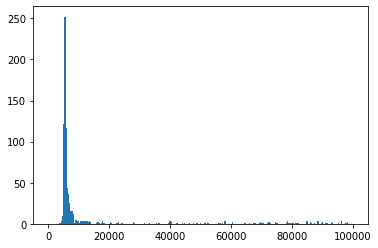

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from background_reduction.b_MC_reduction import b_cleaning
from background_reduction.data_reduction import reduce_background
from data.data_loader import load_data
from get_vertex import obtain_lb_line_of_flight, transverse_momentum, line_plane_intersection, tau_momentum_mass, \
    geometrical_cuts
from masses import get_mass

data_frame_b = load_data(df_name='B_MC')
data_frame_b.dropna(inplace=True)
data_frame_b = b_cleaning(data_frame_b)
data_frame_b = data_frame_b.reset_index(drop=True)
data_frame_b = obtain_lb_line_of_flight(data_frame_b)
data_frame_b = transverse_momentum(data_frame_b)
data_frame_b = line_plane_intersection(data_frame_b)
data_frame_b = tau_momentum_mass(data_frame_b)

particles_associations = [['Kminus_P', 'K'], ['proton_P', 'pi'], ['mu1_P', 'mu'], ['tau_P', 'tau']]
data_frame_b['b_mass'] = get_mass(data_frame=data_frame_b, particles_associations=particles_associations)
plt.hist(data_frame_b['b_mass'], bins='auto', range=[0, 100000])
plt.show()
data_frame_b['B mass region'] = 'middle'
data_frame_b.loc[data_frame_b['b_mass'] < 8000, 'B mass region'] = 'low'
data_frame_b.loc[data_frame_b['b_mass'] > 28000, 'B mass region'] = 'high'

## Geometrical cuts
Several cuts were applied based on the geometry of the problem, after having first been tested on the B Monte Carlo data.
This allowed us to avoid huge $pK\mu\tau$ mass reconstructions.

### $\tau$ and $pK\mu$ alignment
We expect the $\tau$ and the $pK\mu$ to be on opposite sides of the $\Lambda_b$ line of flight.
If this was not the case, momentum could not be conserved. 
As such, if we observe from the reconstruction of the $\tau$ direction that the $\tau$ and $pK\mu$ are on the same side of the $\Lambda_b$ line of flight (aka they are `aligned`), we can deduce that our reconstruction was wrong.
This reconstruction can be wrong for several reasons, one of those being that the muon is at a low angle to the $\Lambda_b$/$pK\mu$ plane, yielding false and improbable results.
We see that bad reconstructions mostly lead to high $pK\mu\tau$ masses, but some seemingly fine events at low $pK\mu\tau$ masses also had bad $\tau$ direction reconstrutions.
Hence only events with the correct `alignment` were kept.

(array([-1.,  1.]), array([332, 613], dtype=int64))


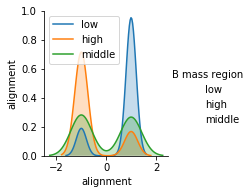

In [4]:
tau_decay_points = data_frame_b['tau_decay_point'].values
pkmu_endvertex_point = data_frame_b[['pKmu_ENDVERTEX_X', 'pKmu_ENDVERTEX_Y', 'pKmu_ENDVERTEX_Z']].values.tolist()
data_frame_b['_tau_dir_x'] = [(tau_decay_points[i] - pkmu_endvertex_point[i])[0] for i in range(len(tau_decay_points))]
data_frame_b['_tau_dir_y'] = [(tau_decay_points[i] - pkmu_endvertex_point[i])[1] for i in range(len(tau_decay_points))]
data_frame_b['_tau_dir_z'] = [(tau_decay_points[i] - pkmu_endvertex_point[i])[2] for i in range(len(tau_decay_points))]
_tau_dir_vars = ['_tau_dir_x', '_tau_dir_y', '_tau_dir_z']
_tau_direction = data_frame_b.loc[:, _tau_dir_vars]
data_frame_b[_tau_dir_vars] = _tau_direction.divide((_tau_direction ** 2).sum(axis=1) ** 0.5, axis='rows')
_tau_direction = data_frame_b.loc[:, _tau_dir_vars]
_pKmu_dir_vars = ['_pKmu_dir_x', '_pKmu_dir_y', '_pKmu_dir_z']
_pKmu_direction = data_frame_b.loc[:, ['pKmu_PX', 'pKmu_PY', 'pKmu_PZ']]
data_frame_b[_pKmu_dir_vars] = _pKmu_direction.divide((_pKmu_direction ** 2).sum(axis=1) ** 0.5, axis='rows')
_pKmu_direction = data_frame_b.loc[:, _pKmu_dir_vars]
_vectors_array_dtype = data_frame_b.loc[:, 'vectors']
_vectors_array = np.vstack(_vectors_array_dtype.to_numpy())
data_frame_b.loc[:, '_lb_dir_x'] = _vectors_array[:, 0]
data_frame_b.loc[:, '_lb_dir_y'] = _vectors_array[:, 1]
data_frame_b.loc[:, '_lb_dir_z'] = _vectors_array[:, 2]
_lb_dir_vars = ['_lb_dir_x', '_lb_dir_y', '_lb_dir_z']
_lb_direction = data_frame_b.loc[:, ['_lb_dir_x', '_lb_dir_y', '_lb_dir_z']]
data_frame_b[_lb_dir_vars] = _lb_direction.divide((_lb_direction ** 2).sum(axis=1) ** 0.5, axis='rows')
_lb_direction = data_frame_b.loc[:, _lb_dir_vars]

__tau_dir = data_frame_b.loc[:, _tau_dir_vars]
__pKmu_dir = data_frame_b.loc[:, _pKmu_dir_vars]
__lb_dir = data_frame_b.loc[:, _lb_dir_vars]

__lb_dir_array = __lb_dir.to_numpy()
__pKmu_dir_array = __pKmu_dir.to_numpy()

_pKmu_longitudinal = __lb_dir_array * (__pKmu_dir_array * __lb_dir_array).sum(axis=1).reshape((-1, 1))
ideal_opposite_dir = -(__pKmu_dir_array - _pKmu_longitudinal)
alignment = (ideal_opposite_dir * __tau_dir.to_numpy()).sum(axis=1)
alignment = np.sign(alignment)
print(np.unique(alignment, return_counts=True))
data_frame_b['alignment'] = alignment

sns.pairplot(data=data_frame_b, x_vars=['alignment'], y_vars=['alignment'], hue='B mass region')
plt.legend()
plt.show()
data_frame = data_frame_b[data_frame_b['alignment'] == 1]

### Angle between tauMu direction and $\Lambda_b$ direction
We see a huge difference in angle between the tauMu direction and $\Lambda_b$ direction for high and low $\Lambda_b$ masses.
Again, if the muon is actually in the plane, we expect potential nonsensical results with the $\tau$ going backwards.
Hence, events with an angle higher than 90 degrees were removed from the data.

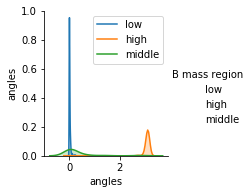

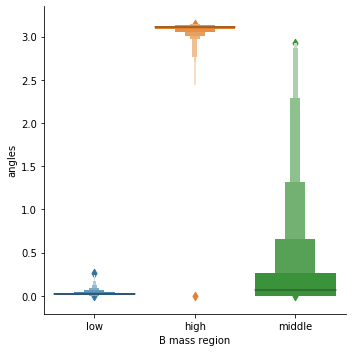

In [5]:
angles = []
for i in range(len(data_frame_b)):
    temp_series = data_frame_b.loc[i]
    end_xyz = [temp_series['pKmu_ENDVERTEX_X'], temp_series['pKmu_ENDVERTEX_Y'], temp_series['pKmu_ENDVERTEX_Z']]
    tau_vector = temp_series['tau_decay_point'] - end_xyz
    vector = temp_series['vectors']
    angle = np.arccos(np.dot(tau_vector, vector) / (np.linalg.norm(tau_vector) * np.linalg.norm(vector)))
    angles.append(angle)
    
data_frame_b['angles'] = angles
sns.pairplot(data=data_frame_b, x_vars=['angles'], y_vars=['angles'], hue='B mass region')
plt.legend()
sns.catplot(
    x="B mass region", y="angles", kind="boxen", data=data_frame_b
)
plt.show()
data_frame = data_frame[data_frame['angles'] < np.pi / 2]

## BDT
Background cleaning which did did not involve PID cuts, cleaning cuts or mass cuts was then optimised with a BDT.
The steps included:
1. Applying the cleaning to the B Monte Carlo data, using that as a signal and defining percentiles beyond which the data would be considered as background
2. Applying the same cleaning (plus PID cleaning) to the $\Lambda_b$ data and extracting background
3. Insert the cleaned B data and cleaned background to determine optimal cuts

### Loading and cleaning the data

In [16]:
df_name = 'Lb_data'

a = load_data(df_name=df_name)
a.dropna(inplace=True)

data_frame_lb = reduce_background(a, True)
data_frame_lb = data_frame_lb.reset_index(drop=True)
data_frame_lb = obtain_lb_line_of_flight(data_frame_lb)
data_frame_lb = transverse_momentum(data_frame_lb)
data_frame_lb = line_plane_intersection(data_frame_lb)
data_frame_lb = tau_momentum_mass(data_frame_lb)
data_frame_lb = geometrical_cuts(data_frame_lb)

particles_associations = [['Kminus_P', 'K'], ['proton_P', 'proton'], ['mu1_P', 'mu'], ['tauMu_P', 'mu']]
data_frame_lb['pkmumu_mass'] = get_mass(data_frame=data_frame_lb, particles_associations=particles_associations)
particles_associations = [['Kminus_P', 'K'], ['proton_P', 'proton'], ['mu1_P', 'mu'], ['tau_P', 'tau']]
data_frame_lb['pkmutau_mass'] = get_mass(data_frame=data_frame_lb, particles_associations=particles_associations)

RangeIndex(start=0, stop=1012436, step=1)
cuts cleaned 50333
jpsi events 17279
jpsi events from Lb 6709
comp 6709 back 5021
j/psi cleaning 31121
PID cleaning 10890
mu1_isMuon cleaning 10890
tauMu_isMuon cleaning 10890
count    5333.000000
mean     2644.842893
std       901.563086
min      1626.646820
25%      2143.353457
50%      2330.917308
75%      2705.716039
max      7939.849605
Name: pkmu_mass, dtype: float64
Lc cleaning 2458
Kmu cleaning 1410
data frame length: 1410, FD 90th percentile: 21.22048151099777
(array([-1.,  1.]), array([552, 202], dtype=int64))


### Getting background outside of signal region

Left: 2, Right: 34
Left: 2 / 400 MeV
Right: 14 / 2000 MeV
Average density: 0.007 / MeV
Expected background in signal region: 56.37


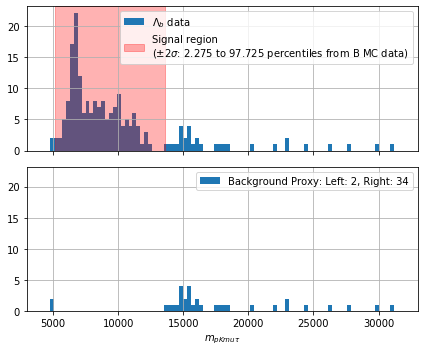

In [17]:
B_mass_limits = [4815, 13271]
Lb_mass_above_B_mass = 341
Lb_mass_limits = [B_mass_limits[0] + Lb_mass_above_B_mass, B_mass_limits[1] + Lb_mass_above_B_mass]

def get_and_plot_background_data(df):
    background_df = df.loc[
        (df.pkmutau_mass < Lb_mass_limits[0]) | (df.pkmutau_mass > Lb_mass_limits[1])
    ]

    background_counts = f"Left: {(background_df.pkmutau_mass < Lb_mass_limits[0]).sum()}, Right: {(background_df.pkmutau_mass > Lb_mass_limits[1]).sum()}"
    print(background_counts)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex='all', sharey='all')
    plot_range = (3000, 33000)
    ax1.hist(df.pkmutau_mass, bins=100, range=plot_range, label='$\Lambda_b$ data')
    ax1.axvspan(*Lb_mass_limits, color='red', alpha=0.3, label='Signal region\n($\pm 2\sigma$: 2.275 to 97.725 percentiles from B MC data)')
    ax2.hist(background_df.pkmutau_mass, bins=100, range=plot_range, label=f'Background Proxy: {background_counts}')
    ax1.grid()
    ax2.grid()
    ax1.legend()
    ax2.legend()
    ax2.set_xlim(plot_range)
    ax2.set_xlabel('$m_{pKmu\\tau}$')
    plt.tight_layout()
    plt.show()
    return background_df


def find_expected_background_in_signal(df):
    background_df = get_and_plot_background_data(df)
    bg_mass = background_df.pkmutau_mass
    
    bin_width = 200
    left_bins = 2
    right_bins = 10

    count_left = ((bg_mass > Lb_mass_limits[0] - left_bins * bin_width) & (bg_mass < Lb_mass_limits[0])).sum()
    count_right = ((bg_mass < Lb_mass_limits[1] + right_bins * bin_width) & (bg_mass > Lb_mass_limits[1])).sum()

    print(f"Left: {count_left} / {bin_width * left_bins} MeV")
    print(f"Right: {count_right} / {bin_width * right_bins} MeV")
    average_density = (count_left + count_right) / ((left_bins + right_bins) * bin_width)
    print(f"Average density: {average_density:.3f} / MeV")

    signal_region_width = Lb_mass_limits[1] - Lb_mass_limits[0]
    print(f"Expected background in signal region: {average_density * signal_region_width:.2f}")


find_expected_background_in_signal(data_frame_lb)
B = 56.37

### Applying BDT to data
We then apply a previously trained BDT on the data.

[19:50:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
Total remaining: 28
After lb=pKmumu mass cut: 10
Total remaining in signal region: 10
Expected background in signal region: 56.370 (before ML classifier), 0.282 (after ML classifier)


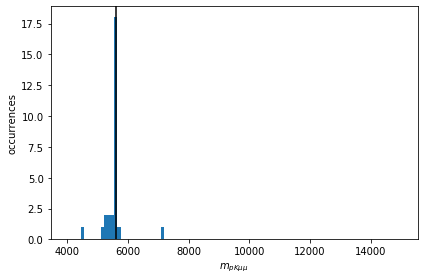

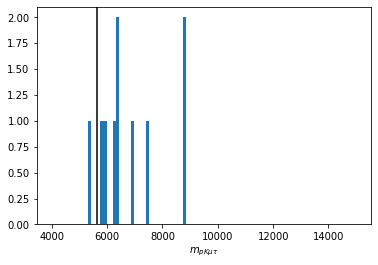

In [20]:
import xgboost


BDT_COLUMNS = [
    'tau_distances_travelled', 'impact_parameter_thingy', 'pKmu_ENDVERTEX_CHI2',
    'Lb_pmu_ISOLATION_BDT1', 'proton_IPCHI2_OWNPV', 'Kminus_IPCHI2_OWNPV',
    'mu1_IPCHI2_OWNPV', 'tauMu_IPCHI2_OWNPV', 'pKmu_IPCHI2_OWNPV',
    'Lb_FDCHI2_OWNPV'
]

xgb = xgboost.XGBClassifier()
xgb.load_model('bdt\\classifier_0.pkl')
model_x = data_frame_lb.loc[:, BDT_COLUMNS]
model_y_pred =  xgb.predict_proba(model_x)[:, 1]
model_y_pred_class = model_y_pred > 0.915
data_frame_lb = data_frame_lb.loc[model_y_pred_class]


print(f"Total remaining: {len(data_frame_lb)}")
lb_pKmumu_mass_cut_mask = (data_frame_lb.pkmumu_mass > 5660) | (data_frame_lb.pkmumu_mass < 5580)
remaining_after_pKmumu_mass_cut = data_frame_lb.loc[lb_pKmumu_mass_cut_mask]
print(f"After lb=pKmumu mass cut: {len(remaining_after_pKmumu_mass_cut)}")

remaining_in_signal_region = remaining_after_pKmumu_mass_cut.loc[(remaining_after_pKmumu_mass_cut.pkmutau_mass > Lb_mass_limits[0]) & (remaining_after_pKmumu_mass_cut.pkmutau_mass < Lb_mass_limits[1])]
print(f"Total remaining in signal region: {len(remaining_in_signal_region)}")

# expected_FPR = 0.012
expected_FPR = 0.005
print(f"Expected background in signal region: {B:.3f} (before ML classifier), {B * expected_FPR:.3f} (after ML classifier)")

n, b, p = plt.hist(data_frame['pkmumu_mass'], bins=100, range=[4000, 15000])
plt.axvline(5620, c='k')
plt.xlabel('$m_{pK\\mu\\mu}$')
plt.ylabel('occurrences')
plt.tight_layout()
plt.show()

plt.hist( data_frame[(data_frame['pkmumu_mass'] < 5620 - 40) | (data_frame['pkmumu_mass'] > 5620 + 40)]['pkmutau_mass'],
        bins=100, range=[4000, 15000])
plt.axvline(5620, c='k')
plt.xlabel('$m_{pK\\mu\\tau}$')
plt.show()

### Branching fraction 

Finally we obtain an upper threshold on the branching fraction from the values above.

Expected background in signal region: 56.370 (before ML classifier), 0.282 (after ML classifier)
Max Likelihood: 2.704e-06  (+1.187e-06, -6.302e-07)
CL 90: 4.208e-06


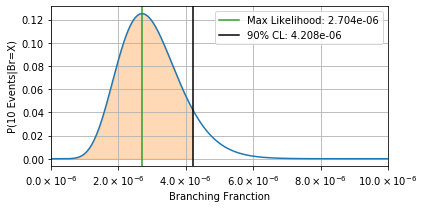

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.integrate import simps, cumtrapz
from scipy.stats import poisson

def calculate_and_plot_branching_fraction(
    B: float,
    S: float,
    model_expected_FPR: float,
    model_expected_TPR: float,
    sigma: float,
    L: float,
    n_b_to_Lb: float,
    pre_model_efficiency: float
):
    # brs = np.logspace(-6, -5, base=10, num=3000)
    brs = np.linspace(0, 1e-5, 3000)

    expected_bg = B * model_expected_FPR
    print(f"Expected background in signal region: {B:.3f} (before ML classifier), {expected_bg:.3f} (after ML classifier)")

    probabilities_of_seen_values = []
    probabilities_of_less_than_seen_values = []

    total_efficiency = pre_model_efficiency * model_expected_TPR
    multiplier = sigma * L * n_b_to_Lb * total_efficiency
    for br in brs:
        expected_signal_seen = multiplier * br
        mu = expected_signal_seen + expected_bg
        probability_of_seen_values = poisson.pmf(S, mu)
        probabilities_of_seen_values.append(probability_of_seen_values)
        probability_of_less_than_seen_values = poisson.cdf(S, mu)
        probabilities_of_less_than_seen_values.append(probability_of_less_than_seen_values)

    probabilities_of_seen_values = np.array(probabilities_of_seen_values)
    probabilities_of_less_than_seen_values = np.array(probabilities_of_less_than_seen_values)

    def calculate_cdf(probabilities: np.ndarray, brs):
        normalised_probabilities = probabilities / probabilities.max()
        area_under_curve = simps(y=normalised_probabilities, x=brs)
        cumulative_areas = cumtrapz(y=normalised_probabilities, x=brs, initial=0)
        cdf = cumulative_areas / area_under_curve
        return cdf

    # cdf = calculate_cdf(probabilities_of_seen_values, brs)
    for (probabilities, ylabel) in [
        (probabilities_of_seen_values, f"P({S} Events|Br=X)"),
        # (probabilities_of_less_than_seen_values, r"$\mathrm{P}(\leq" + str(S) + r" \  \mathrm{Events} | \mathrm{Br}=X )$"),
    ]:
        cdf = calculate_cdf(probabilities, brs)
        max_likelihood = brs[probabilities.argmax()]
        median_likelihood_plus_one_sigma = brs[(cdf > 0.841345).argmax()]
        median_likelihood_minus_one_sigma = brs[(cdf > 0.158655).argmax()]
        print(f"Max Likelihood: {max_likelihood:.3e}  (+{median_likelihood_plus_one_sigma - max_likelihood:.3e}, -{max_likelihood - median_likelihood_minus_one_sigma:.3e})")
    
        cl_90 = brs[(cdf > 0.9).argmax()]
        print(f"CL 90: {cl_90:.3e}")

        plt.figure(figsize=(6, 3))
        ax = plt.gca()
        ax.axvline(max_likelihood, color='C2', label=f"Max Likelihood: {max_likelihood:.3e}")

        ax.plot(brs, probabilities)

        brs_mask = brs < cl_90
        ax.fill_between(brs, probabilities, where=brs_mask, color='C1', alpha=0.3, facecolor='C1')

        ax.axvline(cl_90, color='k', label=f"90% CL: {cl_90:.3e}")

        base_power = -6
        @ticker.FuncFormatter
        def formatter(x, pos):
            latex_str = f'{x * 10 ** -base_power:.1f}' + r'\times 10^{' + str(base_power) + '}'
            return f'${latex_str}$'
        ax.xaxis.set_major_formatter(formatter)

        ax.set_xlabel("Branching Franction")
        ax.set_ylabel(ylabel)
        ax.set_xlim(brs.min(), brs.max())
        ax.grid()
        ax.legend()
        plt.tight_layout()
        # plt.savefig("br_limit_lessthan.png", dpi=300)
        # plt.savefig("br_limit_equal.png", dpi=300)
        plt.savefig("br_limits.png", dpi=300)
        plt.show()
calculate_and_plot_branching_fraction(
    B=56.37,
    S=10,
    model_expected_FPR=0.005,
    model_expected_TPR=0.558,
    sigma=280e-6 * 13.5 / 8,
    L=4e15,
    n_b_to_Lb=0.19,
    pre_model_efficiency=7.80055e-5 * 0.23  # Initial cuts * approximate PID cut efficiency (calculated based on effect on J/psi)
)